# Diffraction

Diffraction with circle aperture

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # this is for surface plots
from matplotlib import cm
import matplotlib.units as units 
from PIL import Image, ImageDraw
from astropy.io import fits
%matplotlib inline

Opitical Parameters

All units are in SI!!!!

In [38]:
pupil_center = (0,0,0)
diameter=1

focal_center = (1,0,0)
focal=1

lambda_center = 0.45e-6
lambda_wide = 0.15e-6
lambda_resolution = lambda_wide/10

Useful TF functions

In [36]:
PAD=4 #sampling size, min=2 SHANON

def ft2d(func):
    ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(func)))
    return ft

def ift2d(func):
    ift = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(func)))
    return ift

def ft1d_freq(x):
    """Calculate the (spatial) frequency array based on the spatial array x."""
    s = np.fft.fftshift(np.fft.fftfreq(x.size, d = x[-1]-x[-2]))
    return s

def padcplx(c):
    """Puts a Complex array in the centre of a zero-filled Complex array.
    PAD defines the padding multiplier for the output array."""
    (nx, ny) = c.shape
    bignx = nx * PAD + 1
    bigny = ny * PAD + 1
    big_c = np.zeros((bignx, bigny), dtype = complex)
    
    dx = int((nx * (PAD-1)) / 2 + 1)
    dy = int((ny * (PAD-1)) / 2 + 1)
    
    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

In [37]:
#Plotting function!

def multi_plot(func, title, loga):
    #Some fancy stuff  
    plt.figure(figsize = (50, 10))
    plt.axis('equal')
    font = {' - size'   : 55}

    plt.subplot(1, 5, 1)
    plt.imshow(np.abs(func))
    plt.colorbar()
    plt.title(title+' - Amplitude')

    plt.subplot(1, 5, 2)
    if(loga == 1):
        plt.imshow(np.log10(np.abs(func)**2))
        plt.colorbar()
        plt.title(title+' - log(I) aka log(PSF)')
    else:
        plt.imshow(np.abs(func)**2)
        plt.colorbar()
        plt.title(title+' - I aka PSF')
        
    plt.subplot(1, 5, 3)
    plt.imshow(np.real(func),cmap = 'RdBu')
    plt.colorbar()
    plt.title(title+' - Real part')

    plt.subplot(1, 5, 4)
    plt.imshow(np.imag(func),cmap = 'RdBu')
    plt.colorbar()
    plt.title(title+' - Imaginary part')

    plt.subplot(1, 5, 5)
    plt.imshow(np.angle(func) ,cmap = 'PiYG')
    plt.colorbar()
    plt.title(title+' - Phase')
    return()

Pupile plan

1 Form

2 Amplitude

3 Phase

0.00285143997718848


Text(0.5, 1.0, 'Aperture')

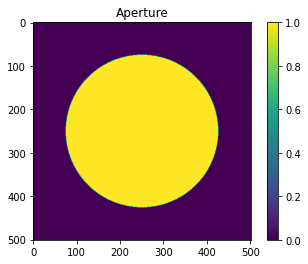

In [39]:
# Define a function for a circular aperture
def circle_mask(im, xc, yc, rad):
    """Create a circular aperture centered on (xc, yc) with radius rcirc."""
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    circ = (newx-xc)**2 + (newy-yc)**2 < rad**2
    diameter_comp = rad*2
    return circ.astype('float'), diameter_comp


def hexagone_mask(im, xc, yc):
#https://stackoverflow.com/posts/3732128/edit
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    hypothenus = npix/4
    diameter_comp = hypothenus
    
    x1 = xc+hypothenus
    x2 = xc+0.5*hypothenus
    x3 = xc-0.5*hypothenus
    x4 = xc-h
    x5 = xc-0.5*hypothenus
    x6 = xc+0.5*hypothenus
    y1 = yc
    y2 = yc+hypothenus*np.sqrt(3/2)
    y3 = yc+hypothenus*np.sqrt(3/2)
    y4 = yc
    y5 = yc-hypothenus*np.sqrt(3/2)
    y6 = yc-hypothenus*np.sqrt(3/2)
      
    polygon = [(x1,y1),(x2,y2),(x3,y3),(x4,y4),(x5,y5),(x6,y6)]
    width = npix
    height = npix

    #Create image and convert to array
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline = 1, fill = 1)
    img = grid*img

    return img


#Amplitude
#Grids
npix = 501 #FFT need a centering grid put a ODD
grid = np.full(shape = (npix,npix),fill_value = 1)


rad = 0.7 * npix/2
aperture, diameter_comp = circle_mask(grid, int(npix/2), int(npix/2), rad)
#aperture = hexagone_mask(grid, int(npix/2), int(npix/2))

#aperture = fits.getdata('../../JWST_pupil.fits')
#npix = len(aperture)
#grid = np.full(shape = (npix,npix),fill_value = 1) #JWST


meter = diameter/diameter_comp
print(meter)

plt.imshow(aperture)
plt.colorbar()
plt.title('Aperture')

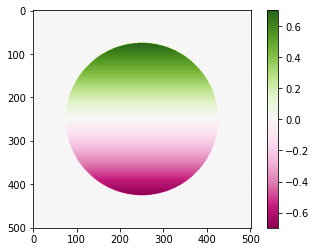

In [13]:
def zernike (Az, xc, yc, grid, norma):
    zer = grid*0
    
    lin2 = np.linspace(0-xc, npix-xc, npix)
    xx, yy = np.meshgrid(lin2, lin2)

    rho = np.sqrt(xx**2+yy**2)
    rho /= norma
    theta = -np.arctan2(yy,-xx)
    
    #TODO Generalizeit!
    Z = [1,
       2*rho*np.cos(theta),2*rho*np.sin(theta),
       np.sqrt(6)*rho**2*np.cos(2*theta),np.sqrt(3)*(rho**2-1),np.sqrt(6)*rho**2*np.sin(2*theta)]
    
    for i in range (len(Az)):
        zer = zer+Az[i]*Z[i]

    return zer


    
Az = [0,0,1,0,0,0]

xc = int(npix/2)+npix%2
yc = xc
rad = len(aperture)


phi = zernike(Az, xc, yc, grid, npix)*aperture

plt.imshow(phi,cmap = 'PiYG')

plt.colorbar()

()

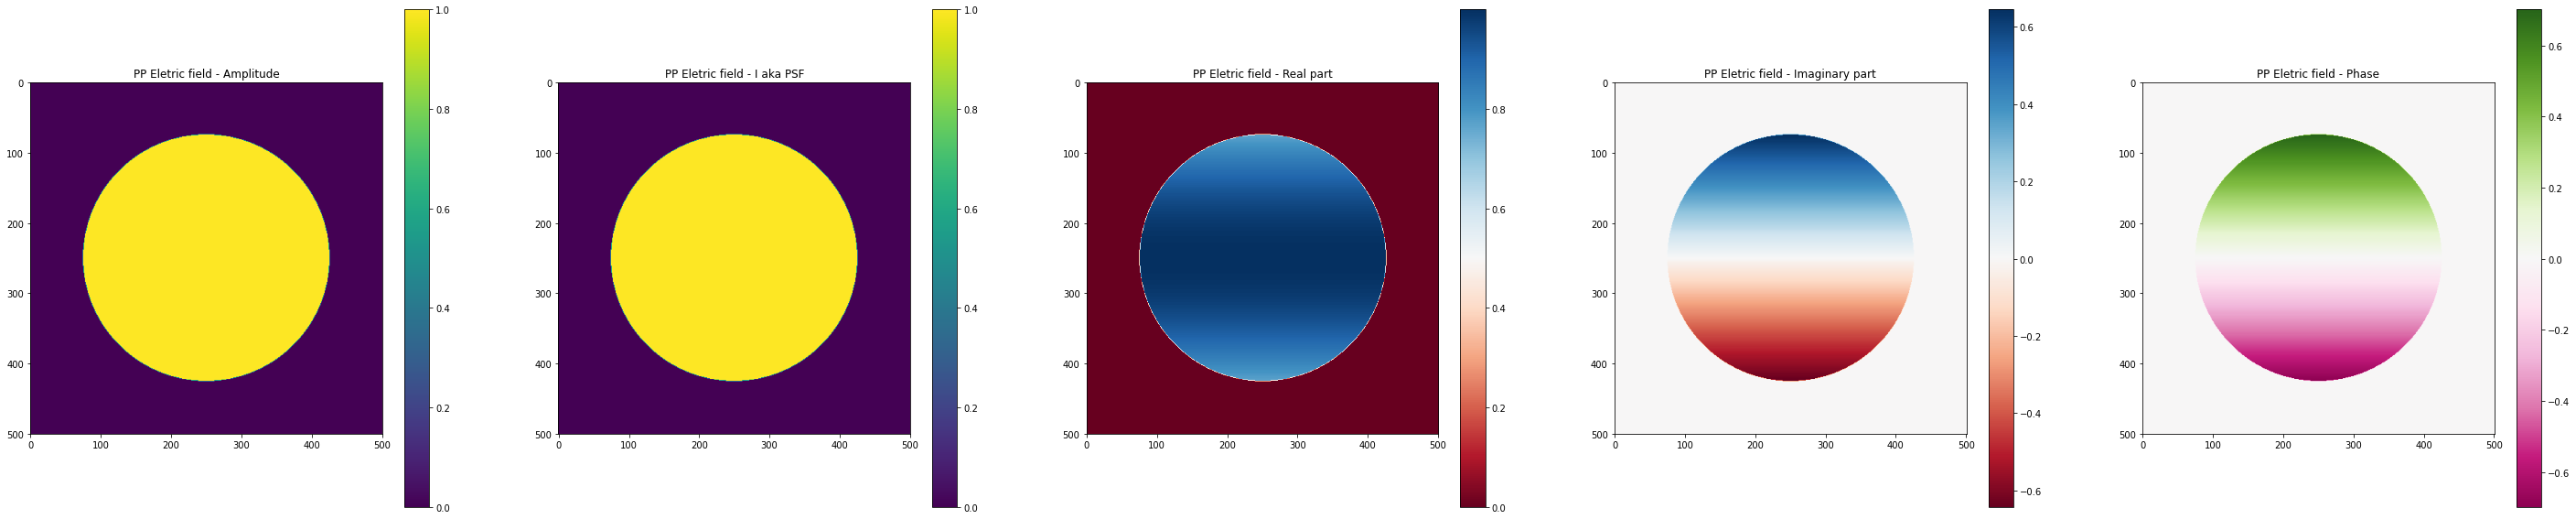

In [14]:
#Electrical Field afetr aperture
Efield = aperture*np.exp(1j*phi)

multi_plot(Efield, "PP Eletric field",loga=0)


Focal plan

1 TF aperture

2 Make coronaph aperture

3 Multiply TF and coronagraph

()

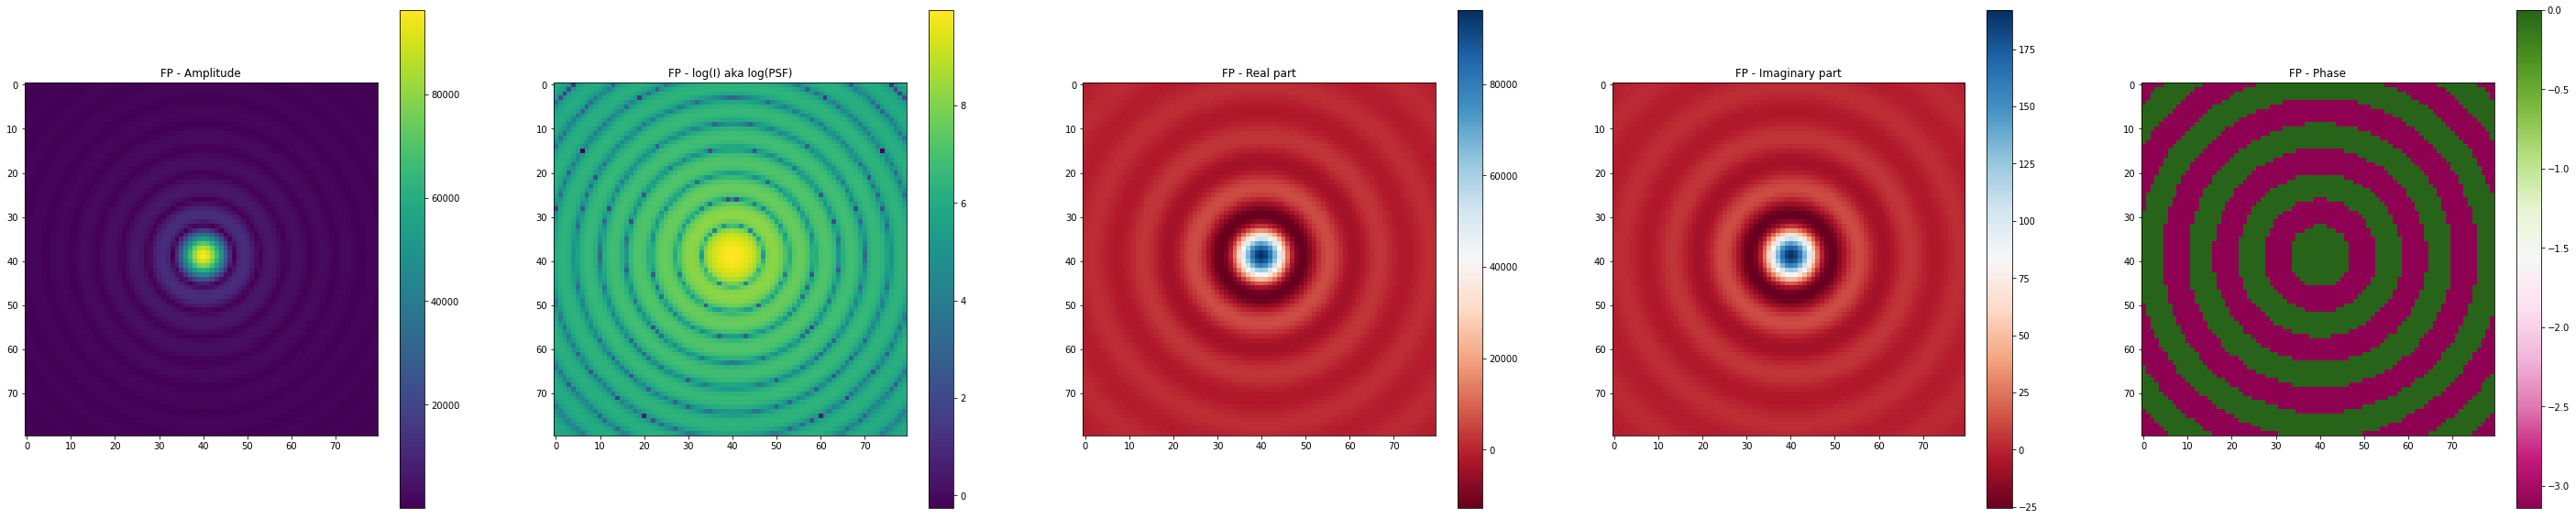

In [15]:
focalplan_BC = ft2d(padcplx(Efield))

focalplan_BC_zoom = zoom(focalplan_BC, 50)

multi_plot(focalplan_BC_zoom, "FP",loga = 1)

#Coronagraph

FPM

LyotStop plan

1 TF focal pla after Conagraph

2 Make (Lyotstop) aperture

3 Multiply TF and (Lyotstop) apertureLyotStop plan


()

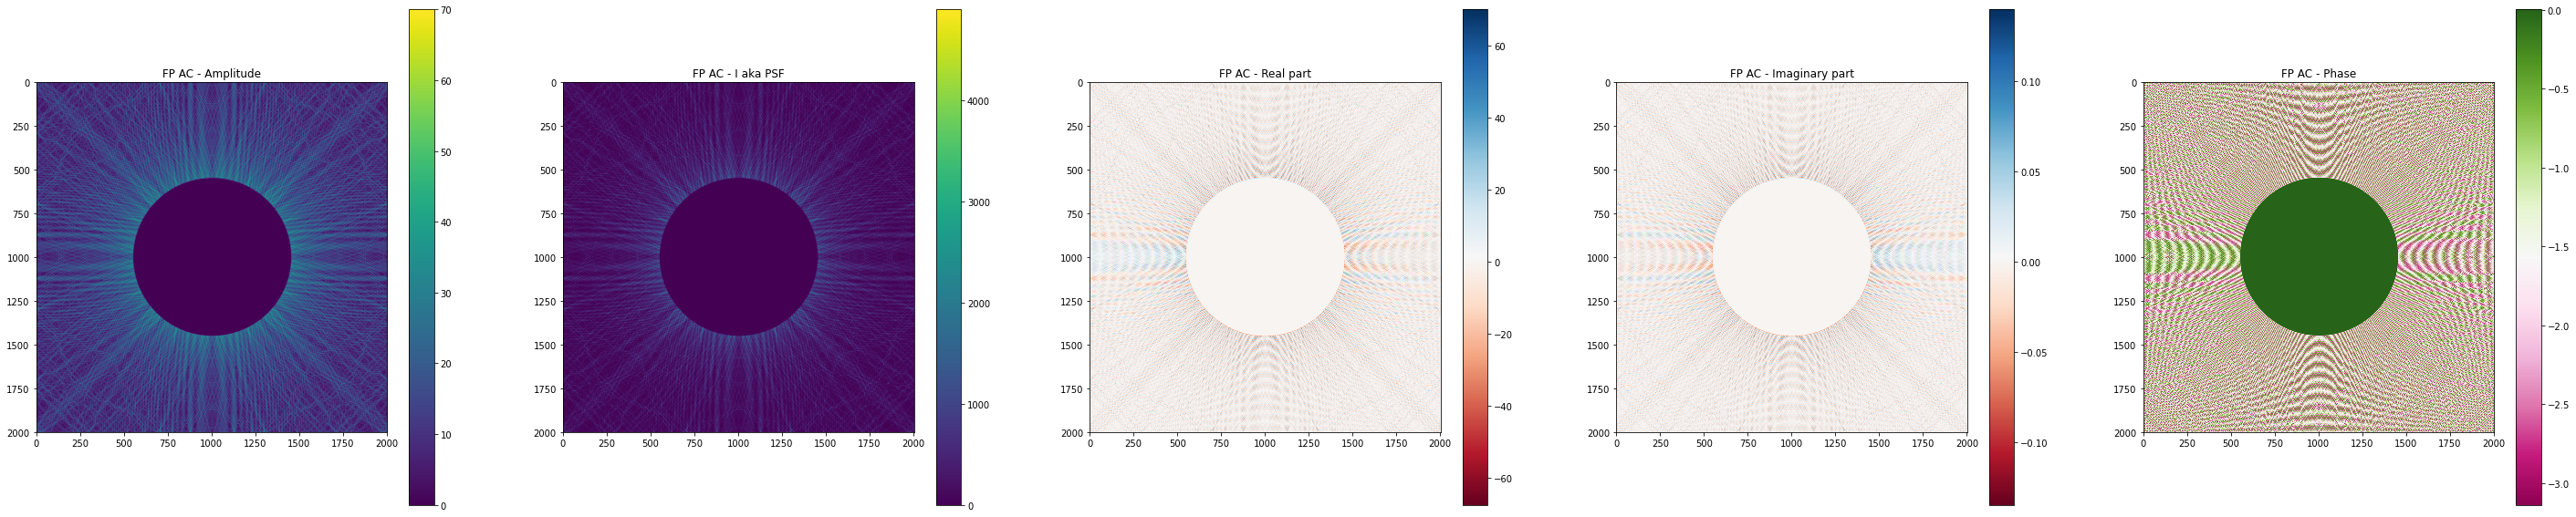

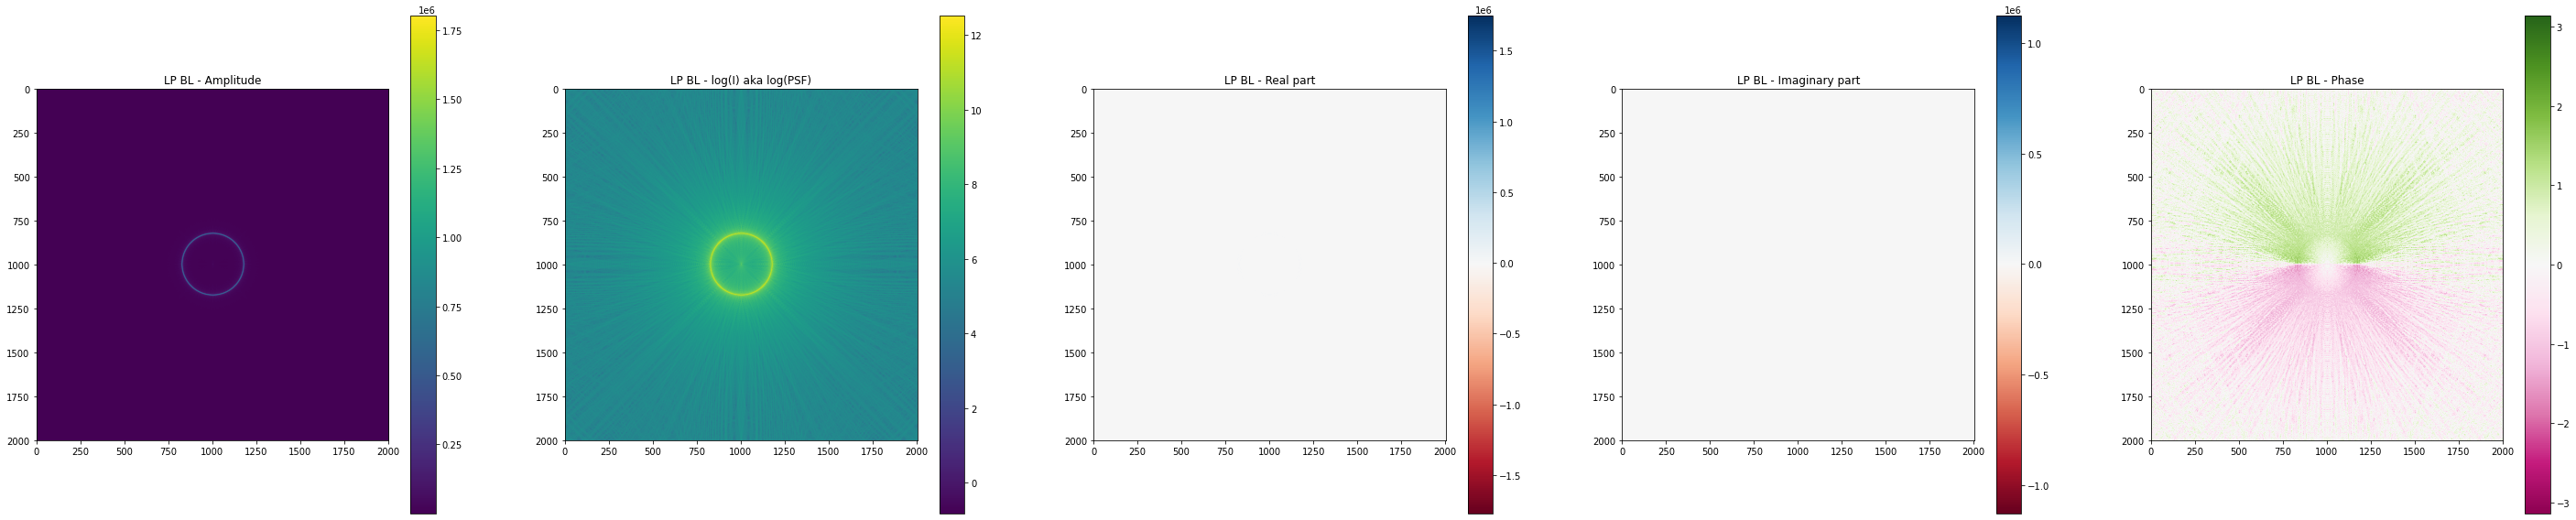

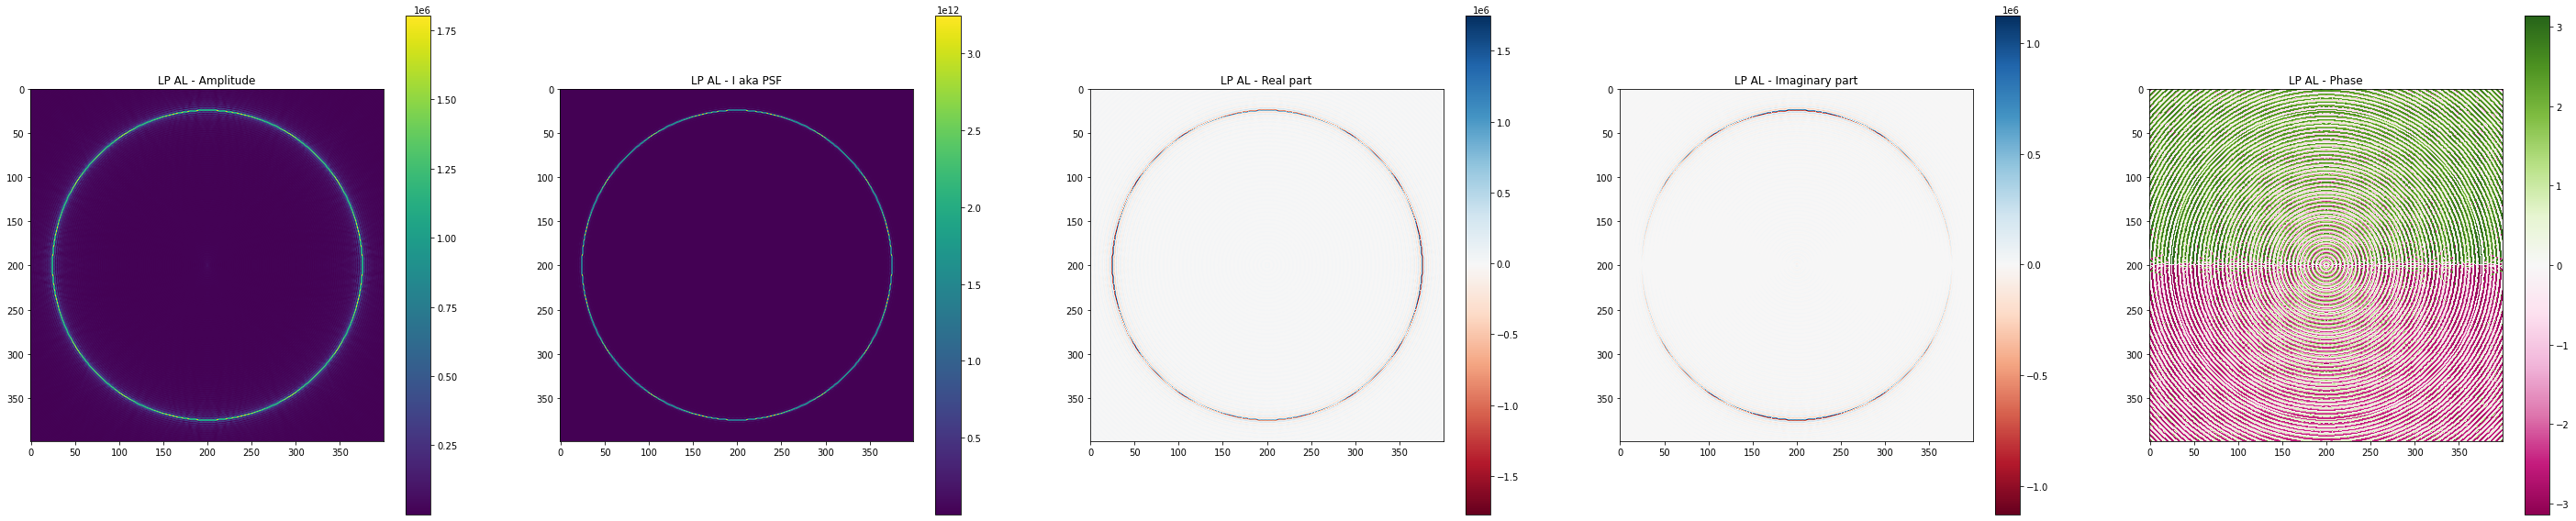

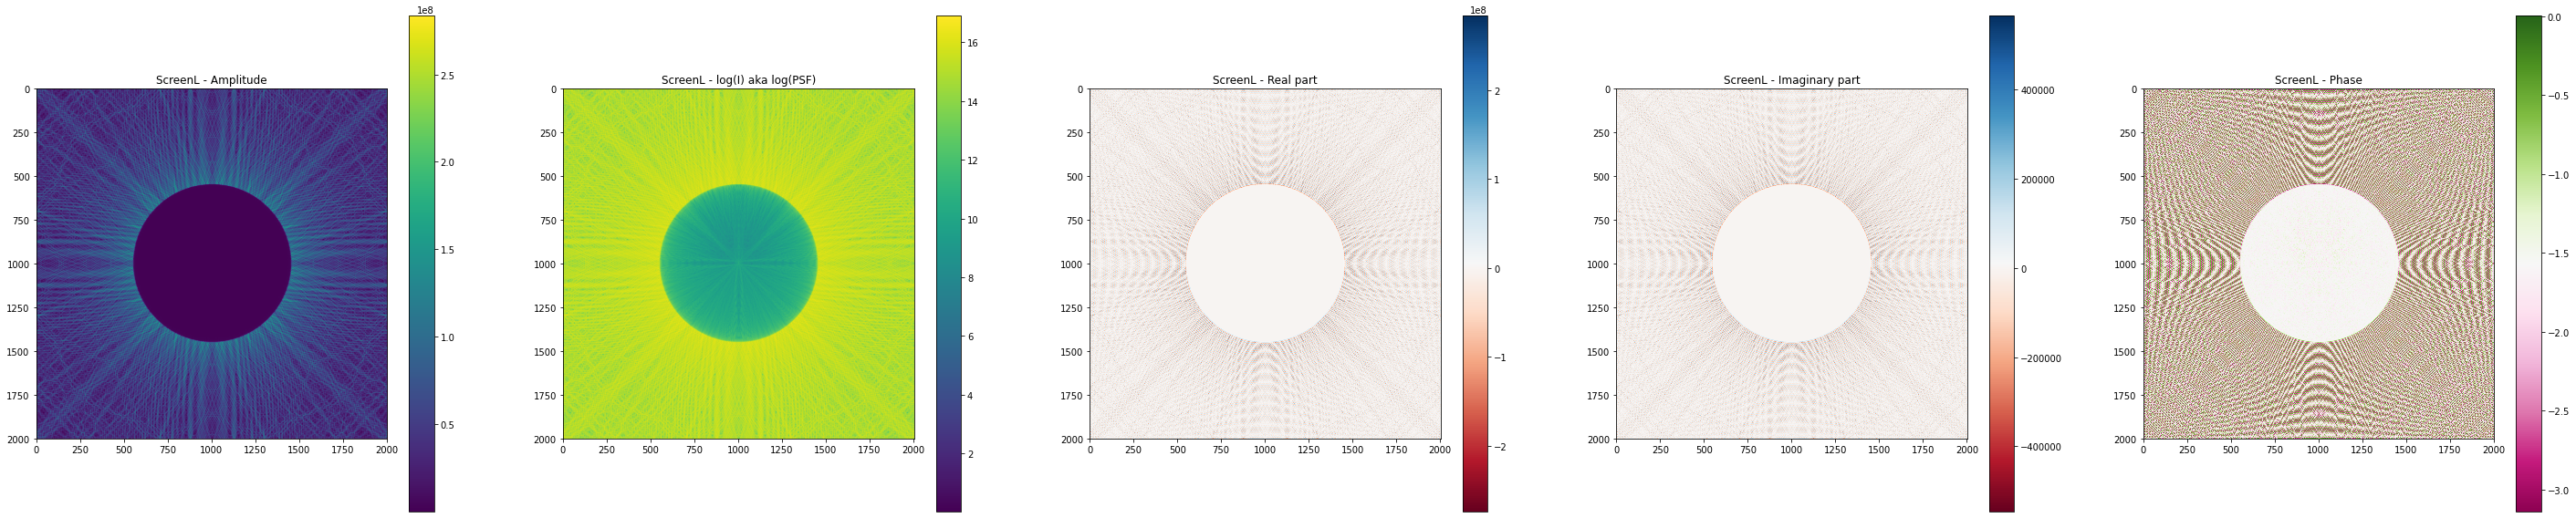

In [16]:
CLC = 1-circle_mask(focalplan_BC, int(focalplan_BC.shape[0]/2), int(focalplan_BC.shape[0]/2), rad*0.9)
focalplan_AC = focalplan_BC*CLC
B_Lyot = ft2d(focalplan_AC)

Lyot = circle_mask(B_Lyot, int(B_Lyot.shape[0]/2), int(B_Lyot.shape[0]/2), rad*0.98)
A_Lyot = B_Lyot*Lyot

screen = ft2d(A_Lyot)


focalplan_AC_zoom = zoom(focalplan_AC, 2)
A_Lyot_zoom = zoom(A_Lyot, 10)
screen_zoom = zoom(screen, 2)

multi_plot(focalplan_AC_zoom, "FP AC",loga = 0)
multi_plot(B_Lyot, "LP BL",loga = 1)
multi_plot(A_Lyot_zoom, "LP AL",0)
multi_plot(screen_zoom, "ScreenL",1)

<ipython-input-18-f443d8380281>:27: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(func2[i])**2))


PP = Pupil Plan, FP = Focal Plan, BC = Before Coronagraph, AC = Before Coronagraph, LP = LyotStop Plan, I = Intensity


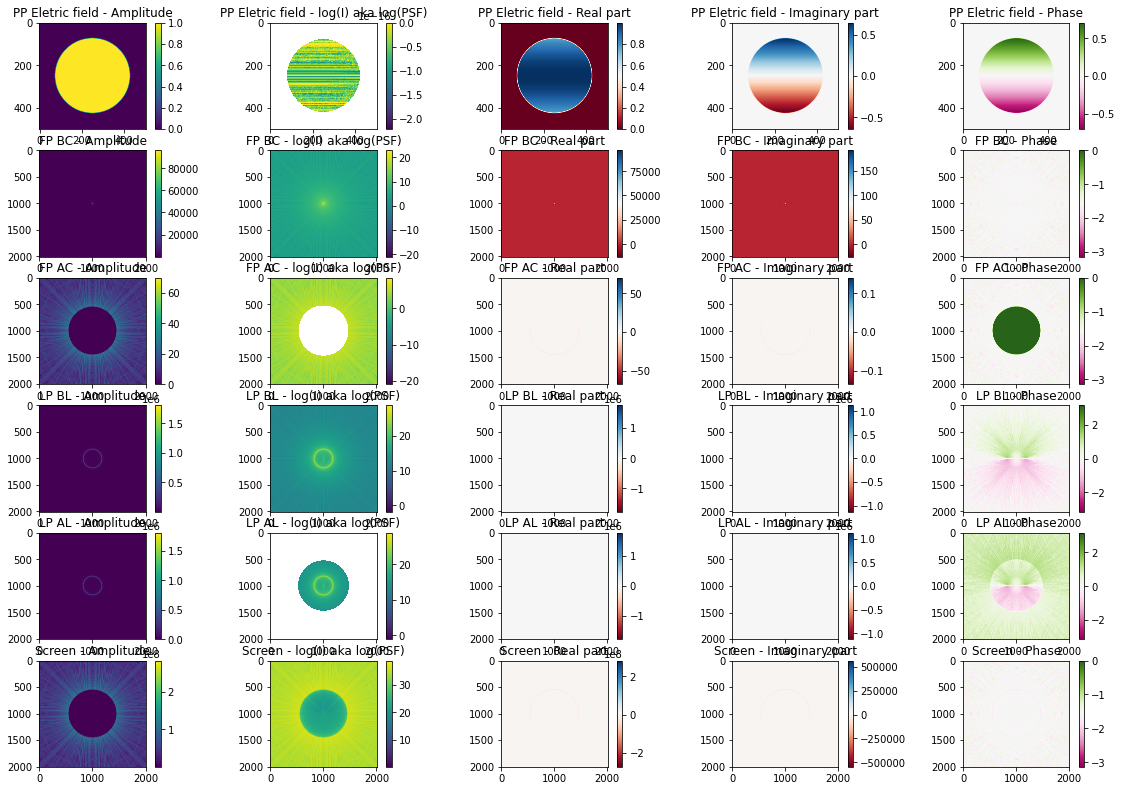

In [18]:
#PINAL ploting Cell
plt.figure(figsize = (20, 70))
#plt.axis('equal')
#plt.subplots_adjust(wspace = 0.5)

font = {' - size'   : 15}

"""
multi_plot(focalplan_BC, "FP BC",1)
multi_plot(focalplan_AC, "FP AC",1)
multi_plot(B_Lyot, "LP BL",1)
multi_plot(A_Lyot, "LP AL",1)
multi_plot(screen, "Screen",1)
"""

func2 = [Efield,focalplan_BC,focalplan_AC,B_Lyot,A_Lyot,screen]
#func2 = [Efield,focalplan_BC]
title2 = ["PP Eletric field","FP BC","FP AC","LP BL","LP AL","Screen"]

for i in range(6):
    plt.subplot(30, 5, i*5+1)
    plt.imshow(np.abs(func2[i]))
    plt.colorbar()
    plt.title(title2[i]+' - Amplitude')

    plt.subplot(30, 5, i*5+2)
    plt.imshow(np.log(np.abs(func2[i])**2))
    plt.colorbar()
    plt.title(title2[i]+' - log(I) aka log(PSF)')

    plt.subplot(30, 5, i*5+3)
    plt.imshow(np.real(func2[i]),cmap = 'RdBu')
    plt.colorbar()
    plt.title(title2[i]+' - Real part')

    plt.subplot(30, 5, i*5+4)
    plt.imshow(np.imag(func2[i]),cmap = 'RdBu')
    plt.colorbar()
    plt.title(title2[i]+' - Imaginary part')

    plt.subplot(30, 5, i*5+5)
    plt.imshow(np.angle(func2[i]) ,cmap = 'PiYG')
    plt.colorbar()
    plt.title(title2[i]+' - Phase')

print("PP = Pupil Plan, FP = Focal Plan, BC = Before Coronagraph, AC = Before Coronagraph, LP = LyotStop Plan, I = Intensity")